In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
# TIGRESS VTK dump reader and units
from vtk_reader import *
import set_units
units=set_units.set_units(muH=1.4271)
units

{'Gcode': <Quantity 2.93655496e-11 cm6 / (g2 s4)>,
 'density': <Quantity 0.03526822 solMass / pc3>,
 'gravitational_potential': <Quantity 1. km2 / s2>,
 'length': <Quantity 1. pc>,
 'magnetic_field': <Quantity 0.54768522 uG>,
 'mass': <Quantity 0.03526822 solMass>,
 'muH': <Quantity 2.38699871e-24 g>,
 'number_density': <Quantity 1. 1 / cm3>,
 'pressure': <Quantity 2.38699871e-14 erg / cm3>,
 'temperature': <Quantity 1. K>,
 'time': <Quantity 0.97779222 Myr>,
 'velocity': <Quantity 1. km / s>}

In [4]:
#Brandon's dust model
from physical_dust import HD_dust_model
dust_model=HD_dust_model()

Currently, original dynamical simulations dump binary data files with a header following a specific format called `VTK`. This contains main physical quantities of `density`, `pressure`, `velocity`, `magnetic field`, etc. UV radiation fields (FUV and EUV) are then calculated by radiation transfer using adaptive ray tracing. Star cluster particles in our dynamical simulation are radiation sources. After post-processing, additional data dump has been made in the same file format. This file includes `radiation energe density` and `density` but `magnetic field`. So, some fields are in both files. In the future, I will rearrange data dump sequence and make it easier to access (or make a better script to hide some complications). For now, we need to access both files.

Finally, `Snu` and `Bx`, `By`, and `Bz` are the input data arrays for your map making.

In [5]:
%%time
ds=AthenaDataSet('./R8_8pc_rst.rad.0300.vtk')
dsmhd=AthenaDataSet('./R8_8pc_rst.0300.vtk')

for k,v in ds.domain.iteritems():
    if k != 'field_map':
        print(k,v)

('ndim', 3)
('nscal', 4)
('center', array([0., 0., 0.], dtype=float32))
('right_edge', array([ 512.,  512., 3584.], dtype=float32))
('Nx', array([128, 128, 896]))
('dx', array([8., 8., 8.], dtype=float32))
('time', 300.0009)
('left_edge', array([ -512.,  -512., -3584.], dtype=float32))
('Lx', array([1024., 1024., 7168.], dtype=float32))
CPU times: user 2.08 ms, sys: 982 µs, total: 3.07 ms
Wall time: 2.35 ms


In [6]:
%%time

# read hydrogen number density and radiation energy density from './R8_8pc_rst.rad.0300.vtk' file
# note that rad_energy_density0 is EUV field
nH=ds.read_all_data('density')
E_FUV=ds.read_all_data('rad_energy_density1')

# converting radiation energy density to G0'
J_FUV0=2.1e-4*au.erg/au.cm**2/au.s/au.sr
J_FUV=E_FUV*(units['pressure']*ac.c/(4*np.pi*au.sr)).cgs
G0prime=np.array((J_FUV/J_FUV0).cgs)

# read in magnetic fields from './R8_8pc_rst.0300.vtk' file
B=dsmhd.read_all_data('magnetic_field')

Bx,By,Bz,=B[...,0],B[...,1],B[...,2]

CPU times: user 6.17 s, sys: 1.05 s, total: 7.22 s
Wall time: 7.23 s


In [7]:
%%time
# calculate S_nu at 353 GHz using Brandon's dust model
freq=353
Snu=dust_model.calculate_Snu(nH,G0prime,freq,deltas=ds.domain['dx'][0])

CPU times: user 10.9 s, sys: 120 ms, total: 11 s
Wall time: 11 s


In [8]:
le=ds.domain['left_edge']
re=ds.domain['right_edge']

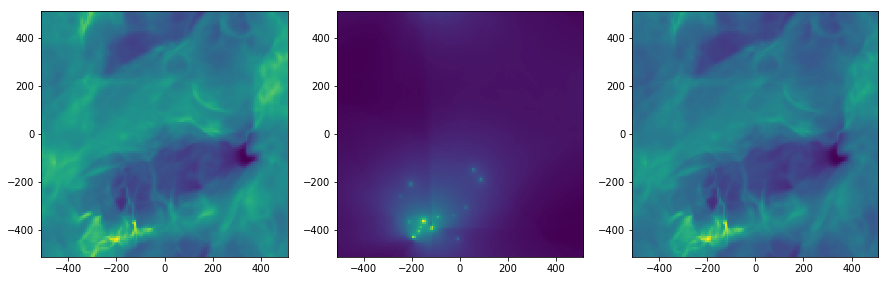

In [9]:
fig,axes=plt.subplots(1,3,figsize=(15,5))
extent=[le[0],re[0],le[1],re[1]]
axes[0].imshow(nH.sum(axis=0),norm=LogNorm(),extent=extent)
axes[1].imshow(G0prime.sum(axis=0),norm=LogNorm(),extent=extent)
axes[2].imshow(Snu.value.sum(axis=0),norm=LogNorm(),extent=extent)